XGBoost'un eğitim süresini düşürme amacıyla geliştirildi.

- XGBoost karar agaclarını(Level-wise strategy) kullanırken, LGBM spitlere(Leaf-wise strategy) odaklanır.
- Breadth-search(BFS) yerine depth-first searh(DFS) yöntemini kullanır.
- Bunlar da XGBoosta göre öğrenme performansınını artırır.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_csv("../Hitters.csv")
df = df.dropna()
dms = pd.get_dummies(df[["League","Division", "NewLeague"]])
y = df["Salary"]
X_ = df.drop(["League", "Division" , "NewLeague" ,"Salary"], axis=1).astype("float64")
X = pd.concat([X_, dms[["League_N","Division_W", "NewLeague_N"]]], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=33)

In [16]:
!pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [41]:
from lightgbm import LGBMRegressor

In [6]:
lgbm_model = LGBMRegressor(min_data_in_leaf=1).fit(X_train, y_train)
# 197 veri için default=20 yüksekti model öğrenmedi, 1'e düşürdüm, bir sonraki süreçte zaten best_params bakacagız

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 19
[LightGBM] [Info] Start training from score 529.037259


In [9]:
y_pred = lgbm_model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
RMSE

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


329.2506070120672

In [33]:
lgbm_params = {"min_data_in_leaf": [1,4],
               "learning_rate": [0.01, 0.5, 1],
               "n_estimators": [10, 20, 50],
               "max_depth": [1,5,7]}

In [35]:
lgbm_cv_model = GridSearchCV(lgbm_model, lgbm_params, cv = 5, n_jobs=-1).fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 19
[LightGBM] [Info] Start training from score 529.037259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [36]:
lgbm_cv_model.best_params_

{'learning_rate': 0.5,
 'max_depth': 5,
 'min_data_in_leaf': 1,
 'n_estimators': 20}

In [47]:
lgbm_tuned = LGBMRegressor(learning_rate=0.5, max_depth= 5, min_data_in_leaf =1, n_estimators =20).fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 19
[LightGBM] [Info] Start training from score 529.037259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [49]:
y_pred = lgbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


312.21539640171255

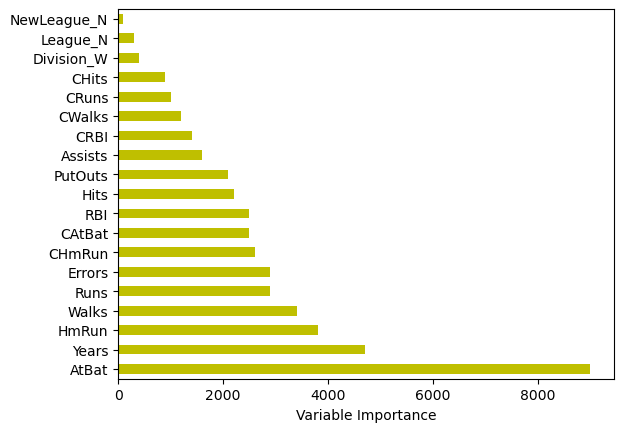

In [51]:
#degisken onem duzeyleri kontrolu
Importance = pd.DataFrame({"Importance": lgbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Importance.sort_values(by = "Importance",
                       axis = 0,
                       ascending=False).plot(kind = "barh", color = "y")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None
